# Comparative Analysis of Image classification models using Machine Learning and CNN

## Data Preparation

### Importing Libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

from pathlib import Path

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

#### Suppressing warnings

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Defining paths to image dataset folder

In [4]:
# Define path to the data directory
data_dir = Path('chest_xray')

# Path to train directory
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

### Creating Training dataframe

In [5]:
# Get the path to the normal and pneumonia sub-directories
train_normal_cases_dir = train_dir / 'NORMAL'
train_pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
train_normal_cases = train_normal_cases_dir.glob('*.jpeg')
train_pneumonia_cases = train_pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in train_normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in train_pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
# train_data = train_data.sample(frac=1., random_state=0).reset_index(drop=True)
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,chest_xray\train\NORMAL\NORMAL2-IM-0589-0001.jpeg,0
1,chest_xray\train\PNEUMONIA\person477_bacteria_...,1
2,chest_xray\train\PNEUMONIA\person471_virus_968...,1
3,chest_xray\train\PNEUMONIA\person392_bacteria_...,1
4,chest_xray\train\NORMAL\NORMAL2-IM-0665-0001.jpeg,0


### Creating Testing dataframe

In [6]:
# Get the path to the normal and pneumonia sub-directories
test_normal_cases_dir = test_dir / 'NORMAL'
test_pneumonia_cases_dir = test_dir / 'PNEUMONIA'

# Get the list of all the images
test_normal_cases = test_normal_cases_dir.glob('*.jpeg')
test_pneumonia_cases = test_pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
test_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in test_normal_cases:
    test_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in test_pneumonia_cases:
    test_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
test_data = pd.DataFrame(test_data, columns=['image', 'label'],index=None)

# Shuffle the data 
# test_data = test_data.sample(frac=1., random_state=0).reset_index(drop=True)
test_data = test_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
test_data.head()

,image,label
0,chest_xray\test\NORMAL\NORMAL2-IM-0300-0001.jpeg,0
1,chest_xray\test\NORMAL\NORMAL2-IM-0030-0001.jpeg,0
2,chest_xray\test\PNEUMONIA\person136_bacteria_6...,1
3,chest_xray\test\PNEUMONIA\person1651_virus_285...,1
4,chest_xray\test\NORMAL\NORMAL2-IM-0058-0001.jpeg,0


<hr>

## Exploratory Data Analysis

### Displaying 5 Pneumonia and Normal case images each

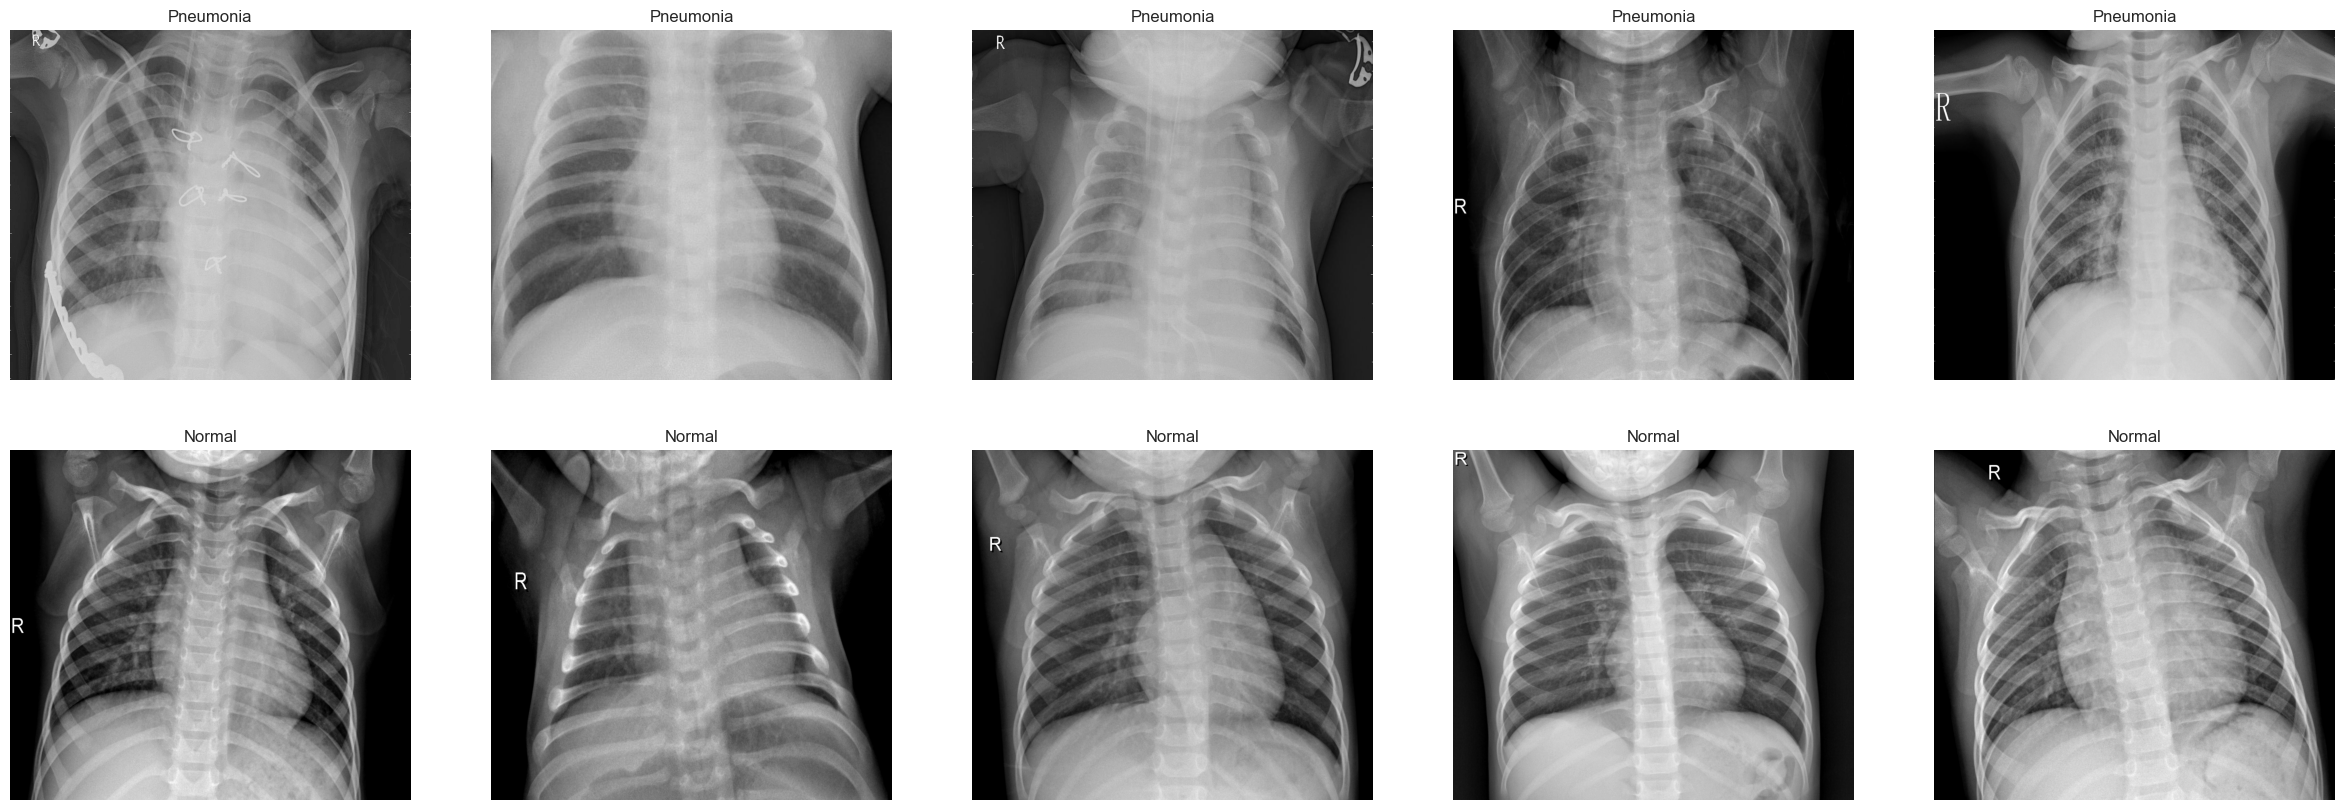

In [7]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
_, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

### Checking the Class distribution

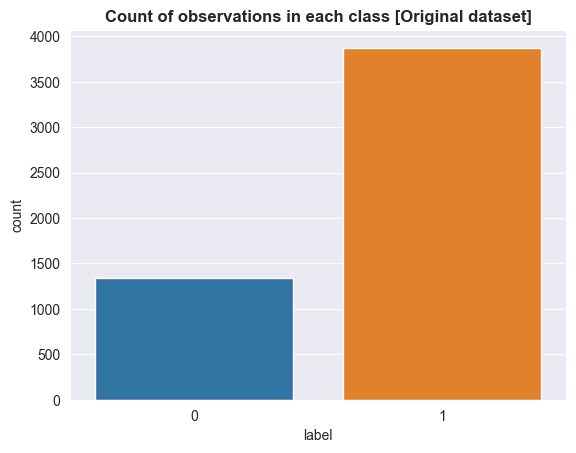

In [8]:
sns.countplot(data=train_data, x='label')

plt.title("Count of observations in each class [Original dataset]", fontweight='bold')
plt.show()

#### Inference
1. Our dataset is unbalanced. We have much lesser normal cases that pneumonia cases. 
2. We will calculate the number of normal cases and take the same number of normal and pneumonia cases

In [9]:
# Finding number of observations in test dataset
len(train_data[train_data['label']==0])

1341

#### Balancing Class distribution
We will take 1300 observations from both classes

In [10]:
train_data_balanced = []

for img in train_data[train_data['label']==1][:1300]['image']:
    train_data_balanced.append((img,1))

for img in train_data[train_data['label']==0][:1300]['image']:
    train_data_balanced.append((img,0))

# Get a pandas dataframe from the data we have in our list 
train_data_balanced = pd.DataFrame(train_data_balanced, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data_balanced = train_data_balanced.sample(frac=1., random_state=0).reset_index(drop=True)

# How the dataframe looks like?
train_data_balanced.head()

,image,label
0,chest_xray\train\PNEUMONIA\person946_bacteria_...,1
1,chest_xray\train\NORMAL\NORMAL2-IM-0466-0001.jpeg,0
2,chest_xray\train\NORMAL\IM-0514-0001.jpeg,0
3,chest_xray\train\PNEUMONIA\person1036_virus_17...,1
4,chest_xray\train\NORMAL\IM-0621-0001.jpeg,0


#### Comparing count of Original and Balanced training dataset

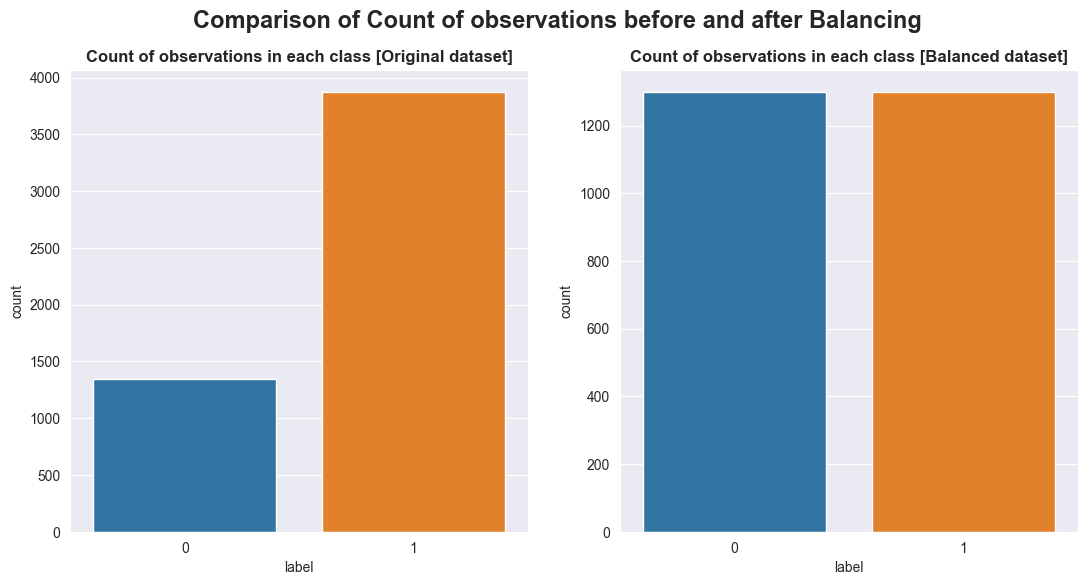

In [11]:
fig = plt.figure(figsize=(13,6))

# Original countplot
plt.subplot(1,2,1)
sns.countplot(data=train_data, x='label')

plt.title("Count of observations in each class [Original dataset]", fontweight='bold')

# Balanced countplot
plt.subplot(1,2,2)
sns.countplot(data=train_data_balanced, x='label')

plt.title("Count of observations in each class [Balanced dataset]", fontweight='bold')

fig.suptitle("Comparison of Count of observations before and after Balancing", fontweight='bold', fontsize=17)
fig.show()

## Inferring useful columns

### Finding the size of each image

In [158]:
sizes = []
for imgPath in train_data_balanced['image']:
    img = imread(imgPath)
    size = img.shape
    sizes.append(size)

train_data_balanced['size'] = sizes
train_data_balanced

,image,label,size
0,chest_xray\train\PNEUMONIA\person145_virus_295...,1,"(552, 968)"
1,chest_xray\train\NORMAL\NORMAL2-IM-0965-0001.jpeg,0,"(1249, 1500)"
2,chest_xray\train\NORMAL\NORMAL2-IM-1123-0001.jpeg,0,"(950, 1384)"
3,chest_xray\train\PNEUMONIA\person23_bacteria_8...,1,"(1072, 1264)"
4,chest_xray\train\NORMAL\NORMAL2-IM-0849-0001.jpeg,0,"(1283, 1704)"
...,...,...,...
2595,chest_xray\train\PNEUMONIA\person68_bacteria_3...,1,"(824, 1032)"
2596,chest_xray\train\NORMAL\NORMAL2-IM-0929-0001.jpeg,0,"(1627, 1906)"
2597,chest_xray\train\PNEUMONIA\person49_bacteria_2...,1,"(704, 1000)"
2598,chest_xray\train\PNEUMONIA\person40_bacteria_2...,1,"(920, 1344)"


### Calculating the image size ratios and vector length of all images

In [159]:
ratios = []
lengths = []
for size in train_data_balanced['size']:
  length = size[1] * size[0]
  ratio = size[1] / size[0]
  lengths.append(length)
  ratios.append(ratio)

train_data_balanced['length'] = lengths
train_data_balanced['ratio'] = ratios
train_data_balanced

,image,label,size,length,ratio
0,chest_xray\train\PNEUMONIA\person145_virus_295...,1,"(552, 968)",534336,1.753623
1,chest_xray\train\NORMAL\NORMAL2-IM-0965-0001.jpeg,0,"(1249, 1500)",1873500,1.200961
2,chest_xray\train\NORMAL\NORMAL2-IM-1123-0001.jpeg,0,"(950, 1384)",1314800,1.456842
3,chest_xray\train\PNEUMONIA\person23_bacteria_8...,1,"(1072, 1264)",1355008,1.179104
4,chest_xray\train\NORMAL\NORMAL2-IM-0849-0001.jpeg,0,"(1283, 1704)",2186232,1.328137
...,...,...,...,...,...
2595,chest_xray\train\PNEUMONIA\person68_bacteria_3...,1,"(824, 1032)",850368,1.252427
2596,chest_xray\train\NORMAL\NORMAL2-IM-0929-0001.jpeg,0,"(1627, 1906)",3101062,1.171481
2597,chest_xray\train\PNEUMONIA\person49_bacteria_2...,1,"(704, 1000)",704000,1.420455
2598,chest_xray\train\PNEUMONIA\person40_bacteria_2...,1,"(920, 1344)",1236480,1.460870


### Exploring the balanced dataset with additional inferred columns

In [160]:
train_data_balanced.describe()

,label,length,ratio
count,2600.000000,2.600000e+03,2600.000000
mean,0.500000,1.711876e+06,1.375561
std,0.500096,1.063772e+06,0.252427
min,0.000000,5.520000e+04,0.877220
25%,0.000000,8.901120e+05,1.203888
50%,0.500000,1.530076e+06,1.333333
75%,1.000000,2.249493e+06,1.499606
max,1.000000,7.532028e+06,3.271523


#### Visualizing the distribution of vector lengths of all images

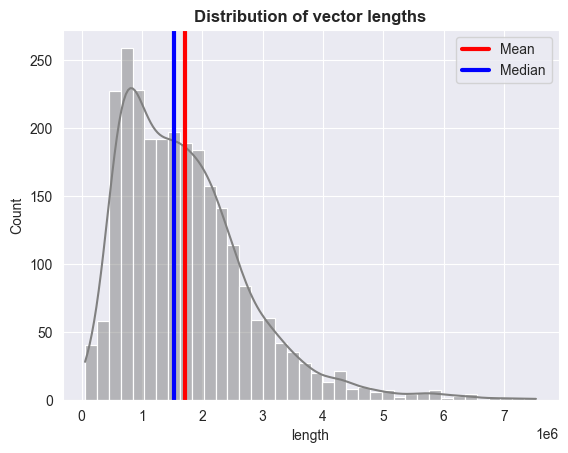

In [161]:
sns.histplot(data=train_data_balanced, x='length', color='gray', kde=True)
plt.axvline(train_data_balanced['length'].mean(), color='red', lw=3, label="Mean")
plt.axvline(train_data_balanced['length'].median(), color='blue', lw=3, label="Median")

plt.title("Distribution of vector lengths", fontweight='bold')
plt.legend()
plt.show()

We will resize all images to the mean size

In [162]:
length = train_data_balanced['length'].min()
print(length)

# We will resize all images into x*x images
x = int(np.sqrt(length))
x

55200


234

<hr>

## Machine Learning Models

##### Function to create the image dataset to be used in Machine Learning model

In [163]:
def makeDataset(data):
    dataset = ""
    for location in data:
        # reading the image from location
        img = imread(location)
        
        # turning rgb images to grayscale
        if len(img.shape) == 3:
            img = rgb2gray(img)

        # resizing to our desired size and scaling it to 255
        img = resize(img, (x, x), anti_aliasing=True) * 255

        # converting to uint8 for saving memory
        img = img.astype(np.uint8)

        # converting to vector
        img = img.reshape(-1)

        # initiating dataset or vstacking onto dataset
        if type(dataset) == str:
            dataset = img
        else:
            dataset = np.vstack([dataset, img])

    # returning dataset
    return dataset

##### Function to create the training and testing datasets

In [164]:
def train_test_split(train, test, train_size=500, test_proportion=0.2):
    test_size = int(test_proportion * train_size)

    X_train = makeDataset(train['image'][:train_size])
    y_train = train['label'][:train_size]
    X_test = makeDataset(test['image'][:test_size])
    y_test = test['label'][:test_size]
    
    return (X_train, X_test, y_train, y_test)

##### Function to perform LDA on the image dataset

In [165]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def doLDA(X_train, y_train, X_test):
    lda = LDA()
    lda.fit(X_train, y_train)
    X_train_lda = lda.transform(X_train)
    X_test_lda = lda.transform(X_test)
    
    return(X_train_lda, X_test_lda)

##### Dictionary that holds the model objects for each type of ML Classifier

In [166]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(gamma='auto'),
    "Gaussian Naive Bayes": GaussianNB(),
    "K Nearest Neighbours": KNeighborsClassifier(n_neighbors=3),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(max_depth=2)
}

### Fitting and Comparing different Machine Learning models

In [167]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Dictionary to hold the accuracy metrics
ml_metrics = {
    "Classifier": [],
    "Test Proportion": [],
    "Accuracy (without LDA)": [],
    "Confusion Matrix (without LDA)": [],
    "Accuracy (with LDA)": [],
    "Confusion Matrix (with LDA)": []
}

# Looping through different test proportions
for test_proportion in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]:

    # Looping through different ML models
    for name, clf in classifiers.items():    
        ml_metrics['Classifier'].append(name)
        ml_metrics["Test Proportion"].append(test_proportion)
        
        # Creating train and test dataset and performing LDA
        X_train, X_test, y_train, y_test = train_test_split(train_data_balanced, test_data, test_proportion=test_proportion)
        X_train_lda, X_test_lda = doLDA(X_train, y_train, X_test)

        # Fitting model to LDA dataset
        clf.fit(X_train_lda, y_train)
        y_pred = clf.predict(X_test_lda)
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        ml_metrics['Accuracy (with LDA)'].append(np.round(acc, decimals=3))
        ml_metrics['Confusion Matrix (with LDA)'].append(cm)

        # Fitting model to non-LDA dataset
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        ml_metrics['Accuracy (without LDA)'].append(np.round(acc, decimals=3))
        ml_metrics['Confusion Matrix (without LDA)'].append(cm)
        
    # Printing confirmation after each test proportion
    print(f"Done for test proportion {test_proportion}")

# Converting metrics dictionary into dataframe and displaying
ml_metrics= pd.DataFrame(ml_metrics)
ml_metrics = ml_metrics.sort_values(['Classifier', 'Test Proportion']).reset_index(drop=True)
ml_metrics

Done for test proportion 0.1
Done for test proportion 0.15
Done for test proportion 0.2
Done for test proportion 0.25
Done for test proportion 0.3
Done for test proportion 0.35


,Classifier,Test Proportion,Accuracy (without LDA),Accuracy (with LDA)
0,Decision Tree,0.10,0.780,0.740
1,Decision Tree,0.15,0.733,0.787
2,Decision Tree,0.20,0.720,0.810
3,Decision Tree,0.25,0.704,0.800
4,Decision Tree,0.30,0.680,0.780
5,Decision Tree,0.35,0.674,0.771
6,Gaussian Naive Bayes,0.10,0.800,0.740
7,Gaussian Naive Bayes,0.15,0.827,0.733
8,Gaussian Naive Bayes,0.20,0.800,0.780
9,Gaussian Naive Bayes,0.25,0.800,0.752


#### Exporting ML accuracy metrics to external csv file

In [168]:
ml_metrics.to_csv("Machine_Learning_Metrics.csv", index=False)

### Visualizing Accuracy Metrics

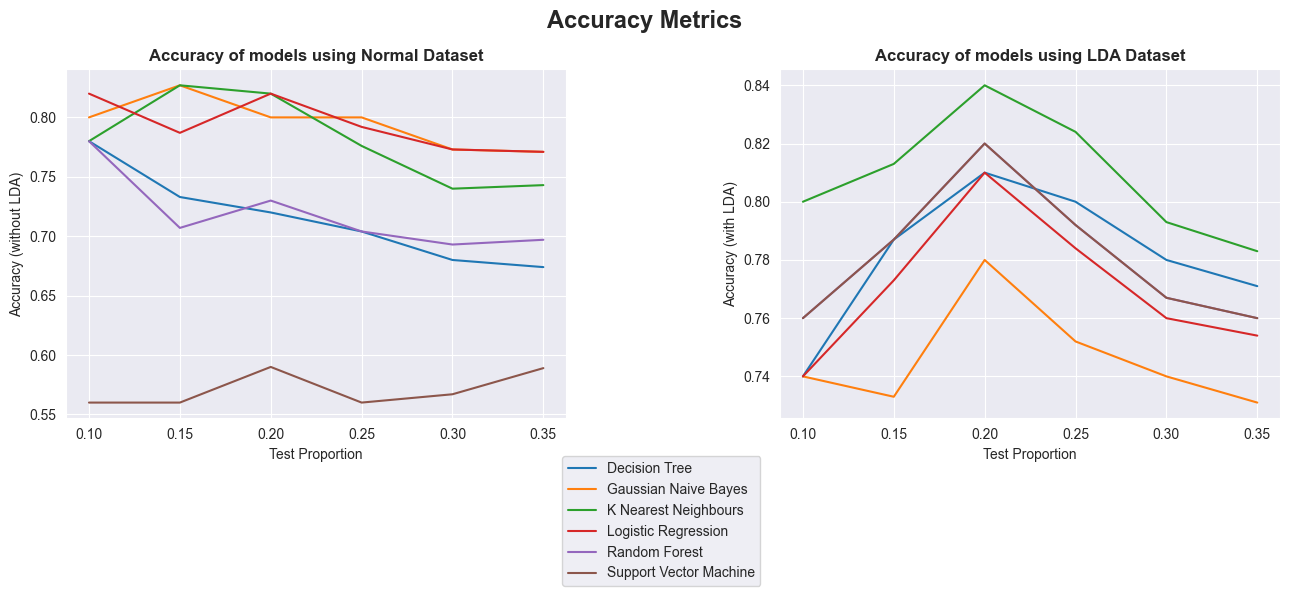

In [169]:
fig = plt.figure(figsize=(13,7))

# Normal dataset accuracy plot
plt.subplot(1,2,1)
sns.lineplot(data=ml_metrics, x='Test Proportion', y='Accuracy (without LDA)', hue='Classifier',legend=False)
plt.title("Accuracy of models using Normal Dataset", fontweight='bold')
# plt.legend(bbox_to_anchor=(1,1))

# LDA dataset accuracy plot
plt.subplot(1,2,2)
sns.lineplot(data=ml_metrics, x='Test Proportion', y='Accuracy (with LDA)', hue='Classifier')
plt.title("Accuracy of models using LDA Dataset", fontweight='bold')
plt.legend(bbox_to_anchor=(-0.45,-0.48), loc='lower left')

# fig.legend()
fig.suptitle("Accuracy Metrics", fontweight='bold', fontsize=17)
fig.tight_layout()
plt.show()

<hr>

## CNN

### Importing CNN libraries

In [12]:
from keras import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

### Resizing images and creating batches

In [13]:
train_datagen = ImageDataGenerator(rescale=1/255, shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
training_set = train_datagen.flow_from_directory(
        directory = train_dir,
        target_size=(64 , 64),
        batch_size=32,
        class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
        directory = test_dir,
        target_size=(64 , 64),
        batch_size=32,
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Creating validation data

In [14]:
validation = ImageDataGenerator(rescale=1./255)
vall = test_datagen.flow_from_directory(
        directory = data_dir / 'val',
        target_size=(64 , 64),
        batch_size=32,
        class_mode='binary')

Found 16 images belonging to 2 classes.


### Creating Convolution model with 3 layers

In [15]:
cnn_model = Sequential()

cnn_model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(.5))

cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


#### Programming early stop

In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=4, mode='min')

### Fitting CNN model

In [19]:
cnn_results = cnn_model.fit(training_set, epochs=10, validation_data=test_set) #, callbacks=early_stop)

Epoch 1/10
163/163 [==============================] - 58s 353ms/step - loss: 0.1807 - accuracy: 0.9304 - val_loss: 0.2573 - val_accuracy: 0.9135
Epoch 2/10
163/163 [==============================] - 58s 353ms/step - loss: 0.1657 - accuracy: 0.9339 - val_loss: 0.3444 - val_accuracy: 0.8750
Epoch 3/10
163/163 [==============================] - 58s 355ms/step - loss: 0.1551 - accuracy: 0.9371 - val_loss: 0.3262 - val_accuracy: 0.8942
Epoch 4/10
163/163 [==============================] - 58s 356ms/step - loss: 0.1601 - accuracy: 0.9400 - val_loss: 0.3331 - val_accuracy: 0.8958
Epoch 5/10
163/163 [==============================] - 58s 355ms/step - loss: 0.1516 - accuracy: 0.9404 - val_loss: 0.3035 - val_accuracy: 0.9087
Epoch 6/10
163/163 [==============================] - 58s 354ms/step - loss: 0.1427 - accuracy: 0.9473 - val_loss: 0.3246 - val_accuracy: 0.9038
Epoch 7/10
163/163 [==============================] - 58s 356ms/step - loss: 0.1449 - accuracy: 0.9482 - val_loss: 0.2464 - val_ac

### Creating functions to Export accuracy and loss metrics and Visualize the data

In [35]:
def get_metrics(history):
    metrics = pd.DataFrame(history)
    metrics['Epoch'] = [x for x in range(len(metrics))]
    metrics = metrics[['Epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy']]
    return metrics


def visualize_metrics(metrics, model):
    fig = plt.figure(figsize=(13,5))

    # Accuracy plot
    plt.subplot(1,2,1)
    sns.lineplot(data=metrics, x='Epoch', y='accuracy', label='train_accuracy')
    sns.lineplot(data=metrics, x='Epoch', y='val_accuracy', label='val_accuracy')

    plt.title("Accuracy versus Epoch", fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower left')

    # Loss plot
    plt.subplot(1,2,2)
    sns.lineplot(data=metrics, x='Epoch', y='loss', label='train_loss')
    sns.lineplot(data=metrics, x='Epoch', y='val_loss', label='val_loss')

    plt.title('Model Loss', fontweight='bold')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='lower left')

    fig.suptitle(f"Comparing Accuracy and Loss in {model}", fontweight='bold', fontsize=17)
    plt.show()

### Visualizing CNN results

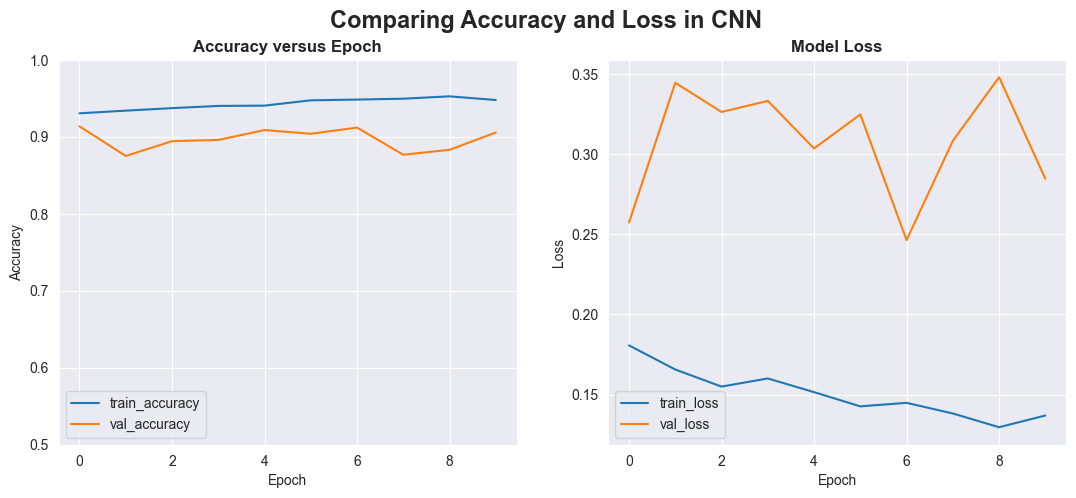

In [36]:
cnn_metrics = get_metrics(cnn_results.history)

visualize_metrics(cnn_metrics, "CNN")

#### Exporting CNN metrics to external csv file

In [39]:
cnn_metrics.to_csv("CNN_Metrics.csv", index=False)

<hr>

# VGG16

### Importing VGG16 libraries

In [23]:
from keras.models import Sequential
from keras.layers import AveragePooling2D, Flatten
from keras.applications import VGG16

### Creating VGG16 model

In [24]:
# we are passing paramers as following
# 1 weights='imagenet' - Using this we are carrying weights as of original weights.
# 2 we want to change the last layer so we are not including top layer
vgg16_base_model = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')

vgg16_model = Sequential([
        vgg16_base_model,
        AveragePooling2D(pool_size=(4, 4)),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.6),
        Dense(1, activation="sigmoid")
    ])

### Displaying model summary

In [25]:
vgg16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 512)        0         
 ooling2D)                                                       
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                      

### Compiling model

In [26]:
vgg16_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

[INFO] compiling model...


### Fitting VGG16 model

In [27]:
vgg_results = vgg16_model.fit(training_set, epochs=10, validation_data=test_set) #, callbacks=early_stop)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_1/dense_2/Relu' defined at (most recent call last):
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\alex9\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\alex9\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "C:\Users\alex9\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\alex9\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\alex9\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\alex9\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\alex9\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\alex9\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\alex9\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\alex9\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\alex9\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\alex9\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\alex9\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\alex9\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\alex9\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\alex9\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\alex9\AppData\Local\Temp\ipykernel_16788\1926817489.py", line 1, in <module>
      vgg_results = vgg16_model.fit(training_set, epochs=10, validation_data=test_set) #, callbacks=early_stop)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\core\dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential_1/dense_2/Relu'
Matrix size-incompatible: In[0]: [32,0], In[1]: [512,128]
	 [[{{node sequential_1/dense_2/Relu}}]] [Op:__inference_train_function_17027]

### Visualizing VGG16 results

In [ ]:
vgg_metrics = get_metrics(vgg_results.history)

visualize_metrics(vgg_metrics, "VGG16")

#### Exporting VGG16 metrics to external csv file

In [ ]:
vgg_metrics.to_csv("VGG16_Metrics.csv", index=False)

In [37]:
# # plot the training loss and accuracy
# N = 10
# plt.style.use("ggplot")
# plt.figure()

# plt.plot(np.arange(0, N), vgg_results.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), vgg_results.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), vgg_results.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), vgg_results.history["val_accuracy"], label="val_acc")

# plt.title("Training Loss and Accuracy on Chest X-ray Dataset")
# plt.xlabel("Epoch")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# # plt.savefig("plot.png")

# plt.show()

<hr>

# Resnet

### Importing Resnet library

In [29]:
from keras.applications import ResNet50

### Creating Resnet model

In [30]:
resnet_base_model = ResNet50(input_shape=(224,224,3), include_top=False, weights='imagenet')

resnet_model = Sequential([
        vgg16_base_model,
        AveragePooling2D(pool_size=(4, 4)),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.6),
        Dense(2, activation="sigmoid")
    ])

### Displaying model summary

In [31]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 average_pooling2d_1 (Averag  (None, 1, 1, 512)        0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                      

### Compiling model

In [32]:
resnet_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Fitting Resnet model

In [33]:
resnet_results = resnet_model.fit(training_set, epochs=10, validation_data=test_set) #, callbacks=early_stop)

Epoch 1/10


ValueError: in user code:

    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 2156, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 5707, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 2) vs (None, 1)).


### Visualizing Resnet results

In [ ]:
resnet_metrics = get_metrics(resnet_results.history)

visualize_metrics(resnet_metrics, "Resnet")

#### Exporting Resnet metrics to external csv file

In [ ]:
resnet_metrics.to_csv("Resnet_Metrics.csv", index=False)

<hr>